In [73]:
import re
import json

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from helpers.geo_helper import GeoPoint

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

plt.rcParams['figure.figsize']=(12,6)

In [69]:
data = pd.read_csv('./data/data-example.csv', index_col=0)

## Drop out extra columns

The columns with a big percentage of null values. They cannot be useful for us.

In [12]:
extra_columns = ['УНП',
                 'Район (области)',
                 'Специалист',
                 'Число спальных мест',
                 'Направление',
                 'На Новый год',
                 'Вид этажа',
                 'Год кап.ремонта',
                 'Услуга агентства',
                 'Срок сдачи',
                 'Условия сдачи',
                 'Населенный пункт',
                 'Предоплата'
                 ]

data.drop(extra_columns, axis=1, inplace=True)

## Fill in N/A values

In [14]:
data['description'].fillna('', inplace=True)
data['Дополнительно'].fillna('', inplace=True)
data['Примечания'].fillna('', inplace=True)
data['photos'].fillna(0, inplace=True)
data['Агентство'].fillna("нет", inplace=True)
data['Балкон'].fillna("нет", inplace=True)
data['Бытовая техника'].fillna('', inplace=True)
data['Телефон'].fillna('нет', inplace=True)
data['Мебель'].fillna('нет', inplace=True)
data['Метро'].fillna('нет', inplace=True)
data['Плита'].fillna('Пропуск', inplace=True)
data['Ремонт'].fillna('Пропуск', inplace=True)
data['Этаж / этажность'].fillna('0 / 0', inplace=True)
data['Соседи по квартире'].fillna('нет', inplace=True)

## Price

In [15]:
# Remove rows without price
data.drop(data[data['price_usa'] == 'Цена договорная'].index, inplace=True)

In [16]:
def clean_price(price):
    return int(''.join(re.findall(r'\d+', re.sub(r'[,.]\d+', ' ', price))))

data['price_usa'] = data['price_usa'].apply(clean_price)
data['price_local'] = data['price_local'].apply(clean_price)

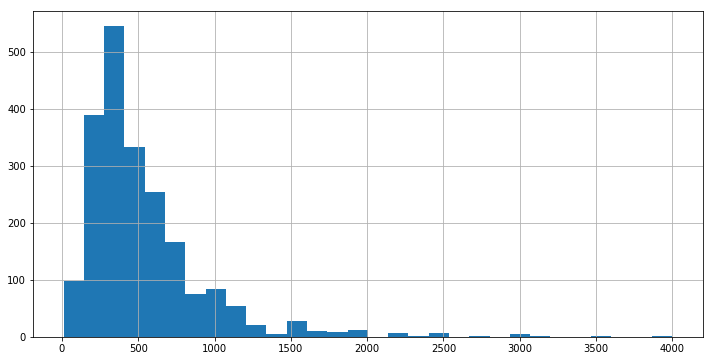

In [17]:
data['price_usa'].hist(bins=30)

## Location

We will proceed only with Minsk records

In [18]:
CITY_TOP_LONGITUDE = 27.3
CITY_BOTTOM_LONGITUDE = 27.8

data.drop(data[(data['longitude'] > CITY_BOTTOM_LONGITUDE) | (data['longitude'] < CITY_TOP_LONGITUDE)].index, 
          inplace=True)

## Neighbors

In [19]:
data.drop(data[data['Соседи по квартире'] != 'нет'].index, inplace=True)

## Rooms

In [20]:
data['rooms'] = data['kv'].apply(lambda kv: 0 if kv.split('/')[0] == ' к' else int(kv.split('/')[0]))

## Living area

In [21]:
data['total_area'] = data['area'].apply(lambda area: int(''.join(re.findall(r'\w+', area.split('/')[0]))))
data['living_area'] = data['area'].apply(lambda area: int(area.split('/')[1]))
data['kitchen_area'] = data['area'].apply(lambda area: int(area.split('/')[2]))

# Replace zero values in total_area with the median value of the apartments with the same number of rooms
for area in ['total_area', 'living_area', 'kitchen_area']:
    data.loc[data[(data[area]==0)].index, area] = data[(data[area] == 0)].merge(
        data.groupby(by='rooms').agg(
            [np.mean, np.min, np.max, np.median]
        )[area].reset_index(),
        on='rooms'
    )['median']

# Drop out rows outside city
data = data[(data['total_area'] <= 300) & (data['rooms'] != 0)]

# Fill in with the median
data['living_area'].fillna(data['living_area'].median(), inplace=True)
data['kitchen_area'].fillna(data['kitchen_area'].median(), inplace=True)

## Balcony

In [22]:
def get_numb_balcony(text):
    if text == 'нет':
        return 0
    elif text.split()[0] in ['лоджия', 'балкон']:
        return 1
    else:
        return 2
    
data['Балкон'] = data['Балкон'].apply(get_numb_balcony)

## Furniture

In [23]:
# Consider that partially installed furniture means no furniture
data['Мебель'].replace('частично', 'нет', inplace=True)
data['Мебель'] = data['Мебель'].apply(lambda furniture: 0 if furniture == 'нет' else 1)

## Phone

In [24]:
data['Телефон'].replace({'нет': 0,
                         'есть': 1,
                         '2 телефона': 2}, 
                        inplace=True)

## Kitchen stove

In [25]:
data['Плита'].replace('Пропуск', 'электрическая', inplace=True)
data['Плита'] = data['Плита'].apply(lambda plate: 0 if plate == 'газовая' else 1)

## Appartment state

In [49]:
# Apartment state:  good (1) or bad (0). 
data['Ремонт'] = data['Ремонт'].apply(lambda repair: 1 if repair in ['евроремонт', 'отличный ремонт'] else 0)

## Is Owner

In [52]:
data['Агентство'] = data['Агентство'].apply(lambda agent: 0 if agent == 'нет' else 1)

## Photos

In [53]:
data['photos_proc'] = data['photos'].clip(0, 25)

## Building Type

In [54]:
data['Тип дома'].fillna('Пропуск', inplace=True)
data['Тип дома'].replace({'кб': 'каркасно-блочный',
                          'КБ': 'каркасно-блочный',
                          'сб': 'Пропуск',
                          'бр': 'Пропуск',
                          'монолитно-каркасный': 'монолитный'
                          }, inplace=True)

## Appliances

In [55]:
def get_tech_from_descr(text):
    result = []
    text = text.lower()
    
    if 'душевая' in text:
        result.append('душевая кабина')
    if 'интернет' in text:
        result.append('интернет')
    if 'музыкальный центр' in text:
        result.append('музыкальный центр')
    if 'dvd' in text:
        result.append('DVD-проигрыватель')
    if 'кондиционер' in text:
        result.append('кондиционер')
    if 'посудомоечная' in text: 
        result.append('посудомоечная машина')
    if 'джакузи' in text:
        result.append('джакузи')
    if any(tv in text for tv in ['телевизор', 'тв', 'телик']):
        result.append('телевизор')
    if 'свч' in text:
        result.append('свч-печь')
    if 'холодильник' in text:
        result.append('холодильник')
    if 'компьютер' in text:
        result.append('компьютер')
    if 'видеомагнитофон' in text:
        result.append('видеомагнитофон')
    if 'домашний кинотеатр' in text:
        result.append('домашний кинотеатр')
    if 'стиральная' in text:
        result.append('стиральная машина')
        
    return ', '.join(result)

In [60]:
# apply only for the records where appliances are not specified and description is not empty
appliances_presented_selector = (data.description != '') & (data['Бытовая техника'] == '')

data.loc[appliances_presented_selector, 'Бытовая техника'] = data.loc[appliances_presented_selector, 'description']\
                                                            .apply(get_tech_from_descr)

## District

In [78]:
geo_points = list(map(lambda point: GeoPoint(point[0], point[1]), data[['latitude', 'longitude']].values))

In [ ]:
geo_points = data.apply(lambda row: GeoPoint(row['latitude'], row['longitude']), axis=1).values

## Undeground Station

In [ ]:
data['Станция метро'] = data.apply(lambda row: GeoPoint(row['latitude'], row['longitude']).get_city_sub_region(), axis=1)